## Captum 
https://github.com/pytorch/captum

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from collections import defaultdict

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

In [2]:
class BasicModule(nn.Module):
    def __init__(self):
        super(BasicModule, self).__init__()
        self.model_name = str(type(self))

    def load(self, path):
        self.load_state_dict(torch.load(path))

    def save(self, path):
        torch.save(self.state_dict(), path)

In [294]:
class SimpleCNN(BasicModule):
    def __init__(self,args):
        super(SimpleCNN, self).__init__()
        # output size of fc layers
        out1 = args['fc1_out']
        out2 = args['fc2_out']
        out3 = args['fc3_out'] # output layer
        self.params = args
        self.k = args['k_max']
        
        # self.k = args['k'] # for k max pooling
        self.kernel_num = args['kernel_num']
        self.dropout = nn.Dropout(args['dropout'])
 
        
        # convolution layers
        filter_sizes = [3, 5, 7, 9]
        self.conv1 = nn.Conv2d(1, self.kernel_num[0], (3, 4), bias=True, padding=0)
        self.conv2 = nn.Conv2d(1, self.kernel_num[1], (5, 4), bias=True, padding=0)
        self.conv3 = nn.Conv2d(1, self.kernel_num[2], (7, 4), bias=True, padding=0)
        self.conv4 = nn.Conv2d(1, self.kernel_num[3], (9, 4), bias=True, padding=0)
#         self.conv5 = nn.Conv2d(1, self.kernel_num[4], (11, 4), bias=True, padding=0)

        
        # fc layers
        self.fc1 = nn.Linear((sum([self.kernel_num[i] * (31-filter_sizes[i]) // 2 for i in range(len(filter_sizes))])), out1, bias=True)
        self.fc2 = nn.Linear(out1, out2, bias=True)
        self.fc3 = nn.Linear(out2, out3, bias=False)
        

    def _conv_and_pool(self, x, conv):

        # x: (batch, 1, size, 4)
        x = conv(x)
        # x: (batch, kernel_num, H_out, 1)
        x = F.relu(x)
        # x: (batch, kernel_num, H_out)
        x = F.max_pool2d(x, kernel_size=(2,1), stride=(2, 1))
        x = x.view(x.size(0), x.size(1) * x.size(2))
        #  (batch, kernel_num * k)
        return x
    
    def setDropout(self, dropout):
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x= torch.Tensor(x)
        # x: (batch, size)
        # x: (batch, sentence_length, embed_dim)
        x = x.view(-1,1, 30, 4)
        x1 = self._conv_and_pool(x, self.conv1)  # (batch, kernel_num * k)
        x2 = self._conv_and_pool(x, self.conv2)  # (batch, kernel_num * k)
        x3 = self._conv_and_pool(x, self.conv3)  # (batch, kernel_num * k)
        x4 = self._conv_and_pool(x, self.conv4)  # (batch, kernel_num * k)
#         x5 = self._conv_and_pool(x, self.conv5)  # (batch, kernel_num * k)

        
        x = torch.cat((x1, x2, x3, x4), 1)  # (batch, 4 * kernel_num * k)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
#         x = 
#         logit = F.log_softmax(x, dim=1)
        return self.fc3(x)

In [4]:
class DNADataset(Dataset):
    
    def __init__(self, data, size):
        super(DNADataset, self).__init__()
        self.size = size
        self.x = np.zeros((len(data),size, 4))
        self.y = []

        for I in range(len(data)):
            self.y.append(data[I][1])
            if type(data[0][0])==str:
                for i in range(size):
                    seq = data[I][0].lower()
                    # one hot encoding
                    pos = "acgt".find(seq[i])
                    if pos >= 0:
                        self.x[I][i][pos] = 1
            else:
                self.x[I] = data[I][0]
        self.x = torch.FloatTensor(self.x)
        self.y = torch.FloatTensor(self.y)

        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    # return a subset of dataset of given range
    def get_subset(self, start, end):
        
        return DNADataset([(self.x[i],self.y[i]) for i in range(start, end)], self.size)

In [5]:
#
def load_data(file):
    data = []
    with open(file,"r") as f:
        for line in f:
            line = line.split()
            data.append((line[0], float(line[1])))
    return data

In [350]:

def encoding_meanings(length):
    seq = []
    for i in range(length):
        bases = ("A%s C%s G%s T%s"%(i,i,i,i)).split()
        for b in bases:
            seq.append(b)
    return seq

# convert one-hot to GCAT seq
def encoding_to_seq(encoding):
    encoding = encoding.view(-1,4)
    seq = ['N'] * len(encoding)
    s = 'ACGT'
    for j in range(len(encoding)):
        for i in range(4):
            if encoding[j][i] == 1.0:
                seq[j] = s[i]
                break
    return seq

# convert one-hot to GCAT seq
def encoding_to_long_seq(encoding):
    encoding = encoding.view(-1,4)
    seq = []
    s = 'ACGT'
    for j in range(len(encoding)):
#         seq.append([])
        for i in range(4):
            if encoding[j][i] == 1.0:
                seq.append("%s_%s"%(s[i], j))
            elif encoding[j][i] == 0.0:
                seq.append("!%s_%s"%(s[i], j))
                
    return seq

In [351]:
encoding_meanings(2)

['A0', 'C0', 'G0', 'T0', 'A1', 'C1', 'G1', 'T1']

In [7]:
# mask i-th base in a seq
def mask_base(tensor, mask_idx):
    rt = torch.zeros(tensor.shape)
    for i in range(len(tensor)):
        if i not in mask_idx:
            rt[i] = tensor[i]
    return rt

In [8]:
#
train_set = DNADataset(load_data("../Cas9_predict_indel/dataset/train_txt"),30)
test_set = DNADataset(load_data("../Cas9_predict_indel/dataset/test_txt"),30)


In [132]:
baseline = train_set.x[1:].mean(axis=0).numpy()

In [295]:
args = {
    'kernel_num': [110, 60, 40, 30],
    'dropout': 0.5,
    'fc1_out': 80,
    'fc2_out': 60,
    'fc3_out': 1,
    'input_max_length':30,
    'k_max' : 1
}
model = SimpleCNN(args)
model.load("../Cas9_predict_indel/model/cnn_3579_110-60-40-30_80-60_90_0.678.model")
model.eval()

SimpleCNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(1, 110, kernel_size=(3, 4), stride=(1, 1))
  (conv2): Conv2d(1, 60, kernel_size=(5, 4), stride=(1, 1))
  (conv3): Conv2d(1, 40, kernel_size=(7, 4), stride=(1, 1))
  (conv4): Conv2d(1, 30, kernel_size=(9, 4), stride=(1, 1))
  (fc1): Linear(in_features=3130, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=1, bias=False)
)

In [22]:
import seaborn as sns
sns.set_theme()

In [23]:
import pandas as pd

In [110]:
def get_attr(x, model, baseline, method="IG"):
    attr = None
    baseline = torch.FloatTensor(baseline).view(1,30,4)
    if method == 'IG':
        explainer = IntegratedGradients(model)
#         model(x.view(1,30,4))
        attr = explainer.attribute(x, baseline, target=0, return_convergence_delta=False)
    elif method == 'DL':
        explainer = DeepLift(model)
#         baseline = torch.zeros((1,30,4))
#         model(x.view(1,30,4))
        attr = explainer.attribute(x, baseline, target=0, return_convergence_delta=False)
    return attr.numpy()[0]

In [107]:
def plot_attr(attr,x,y):
#     print(attr)
    attr = pd.DataFrame([sum(l) for l in attr], index=encoding_to_seq(x))
    sns.set(sns.set(rc = {'figure.figsize':(18,5)}))
    # sns.barplot(attr)
    attr.plot(kind='bar')
    print(y, model(x))


In [108]:
ig_attr.sum()

25.732098431154963

500

In [149]:
shap.force_plot(4.189, ig_attr.reshape(120), encoding_to_long_seq(test_set.x[test_case_index]))

In [167]:
def attr_global(inp, model, baseline, method="IG"):
    """
    A: white
    C: Red
    G: Green
    T: Blue
    """
    attr = []
    for x in inp:
        a = get_attr(x.view(1,30,4), model=model, method='IG', baseline=baseline)
        attr.append(a)
    return np.array(attr)

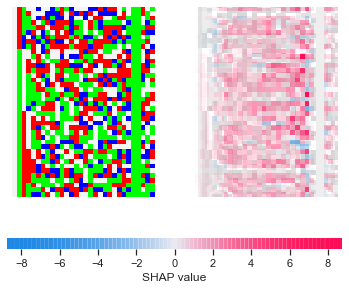

In [171]:
ig_global_values = attr_global(test_set.x[40:80], model, baseline)
shap.image_plot(ig_global_values, enable_color(test_set.x[40:80]))

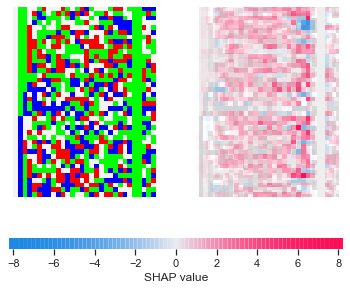

In [170]:
ig_global_values = attr_global(test_set.x[80:120], model, baseline)
shap.image_plot(ig_global_values, enable_color(test_set.x[80:120]))

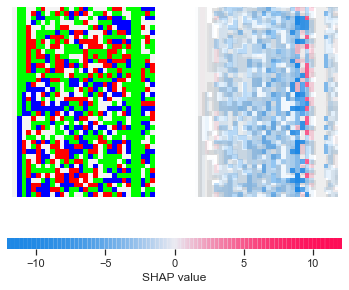

In [326]:
shap.image_plot(shap_values, enable_color(test_set.x[80:120]), width=220)

tensor(35.2791) tensor([[21.3200]], grad_fn=<MmBackward>)


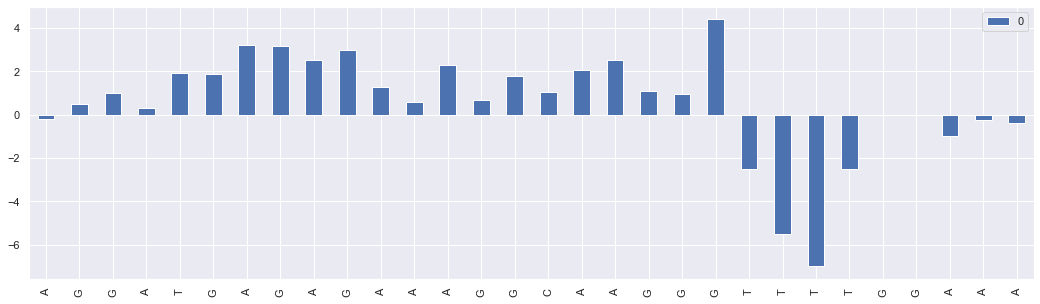

In [201]:
test_case_index = 83
ig_attr = get_attr(test_set[test_case_index][0].view(1,30,4), model=model, method='IG', baseline=baseline)
plot_attr( ig_attr, test_set.x[test_case_index].view(1,30,4), test_set.y[test_case_index])

In [51]:
import shap

In [165]:
def enable_color(arr):
    rt = []
    for x in arr.numpy():
        rt.append([])
        for base in x:
            if base[0] == 1.0:
                rt[-1].append([0.96,0.96,0.96])
            else:
                rt[-1].append(base[1:])
    return np.array(rt)

In [375]:
# explainer = shap.DeepExplainer(model,  train_set.x[2500:5000])
explainer = shap.GradientExplainer(model, train_set.x)
# explainer = shap.Explainer(model, shap.maskers.Independent(train_set.x.view(-1, 120).numpy()))

In [297]:
# def msk(mask, x):
#     rt = (x.numpy().reshape(120) * mask).reshape(30,4)
#     print (type(rt))
#     return torch.Tensor(rt)

In [353]:
model.training = False
shap_values = explainer.shap_values(test_set.x)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [54]:
# init the JS visualization code
shap.initjs()

In [129]:
explainer.expected_value[0]

36.127064

In [316]:
explainer.expected_value[0]

36.990395

In [370]:
shap_values.reshape(-1, 120).shape

(542, 120)

In [367]:
shap_values[1]-shap_values[2]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.53354517,  0.        ,  0.        ,  0.51769435],
       [ 0.        , -0.07867512,  0.11112577,  0.        ],
       [-0.85382736,  0.        ,  0.        ,  1.81247221],
       [-2.30234107,  0.        , -0.96250333,  0.        ],
       [ 2.33110803,  0.25609982,  0.        ,  0.        ],
       [ 0.        ,  0.2015233 , -1.47988468,  0.        ],
       [-1.85587129,  0.        ,  0.        ,  3.23272919],
       [-1.23247349,  0.        , -0.34243691,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.4477219 ,  1.68218517,  0.        ],
       [ 0.        , -0.90270716, -0.19509894,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.

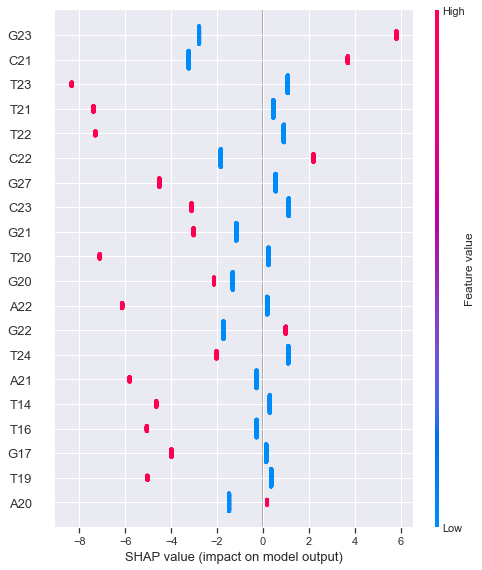

In [377]:
shap.summary_plot(shap_values.reshape(-1,120), features=test_set.x.view(-1,120).numpy(), feature_names=encoding_meanings(30),
                 plot_type='dot')

In [307]:
shap.force_plot(34.8, shap_values[3].reshape(120), encoding_to_long_seq(test_set.x[83]))

In [125]:
# train first 1000, test first 200
shap.force_plot(explainer.expected_value[0], shap_values[0].reshape(120), encoding_to_long_seq(test_set.x[0]))

In [128]:
# train first 3000, test first 500
shap.force_plot(explainer.expected_value[0], shap_values[0].reshape(120), encoding_to_long_seq(test_set.x[0]))

In [136]:
shap_values.shape

(500, 30, 4)

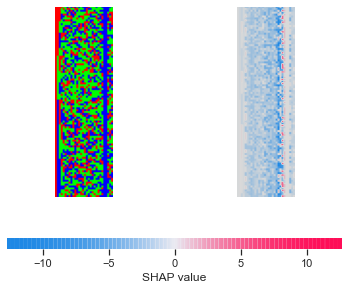

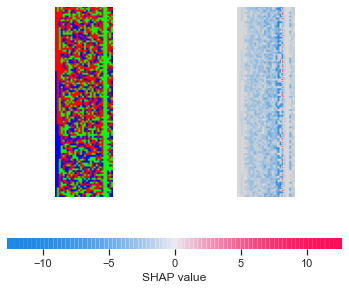

In [159]:
shap.image_plot(shap_values[100:200], test_set.x.numpy()[100:200])

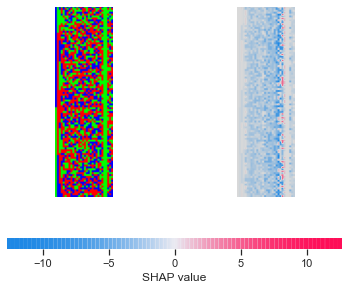

In [160]:
shap.image_plot(shap_values[200:300], test_set.x.numpy()[200:300])

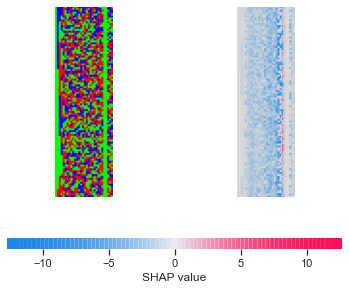

In [164]:
shap.image_plot(shap_values[300:400], test_set.x.numpy()[300:400])

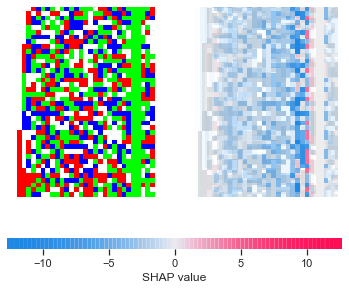

In [194]:
shap.image_plot(shap_values[:40], enable_color(test_set.x[:40]))

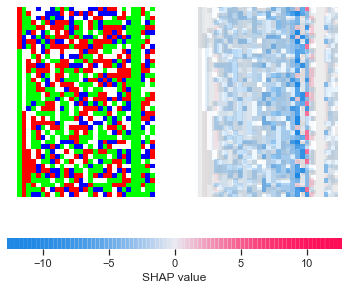

In [195]:
shap.image_plot(shap_values[40:80], enable_color(test_set.x[40:80]))

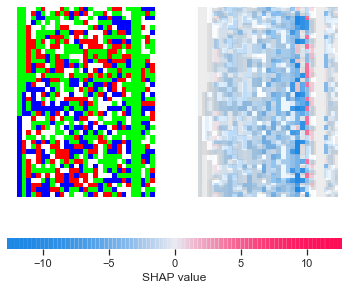

In [196]:
shap.image_plot(shap_values[80:120], enable_color(test_set.x[80:120]))

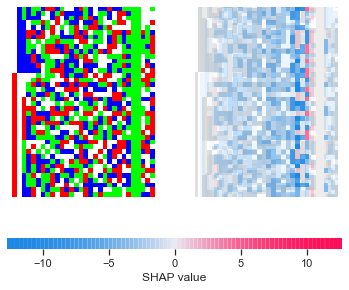

In [197]:
shap.image_plot(shap_values[120:160], enable_color(test_set.x[120:160]))

In [178]:
np.array([1,0,0,0]) + np.array([0,1,1,1])

array([1, 1, 1, 1])